# Model Interpretation for Pretrained VGG-16 Model: Neural activation classification with Autoencoder

This notebook demonstrates how to apply model interpretability algorithms on pretrained VGG-16 model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

Captum library privides function of Layer Conductance, that helps to evaluate importance of each neuron within a given Layer

In [ ]:
pip install captum

In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [ ]:
model = models.vgg16(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-01-18 22:17:08--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.138.248, 52.217.175.56, 54.231.171.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.138.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.03s   

2024-01-18 22:17:08 (1.33 MB/s) - ‘/root/.torch/models/imagenet_class_index.json.1’ saved [35363/35363]



In [ ]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [ ]:
### Rename files

import os
import glob

# Replace these values with your desired folder and renaming criteria
folder_path = '/content'
file_extension = '.jpg'  # Change to the desired file extension
name_pattern = 'animal_{}'  # Change to your preferred name pattern

# Get a list of files that match the criteria
files_to_rename = glob.glob(os.path.join(folder_path, f"*{file_extension}"))

# Iterate through the files and rename them
for index, old_file_path in enumerate(files_to_rename):
    # Extract the file's base name without extension
    base_name = os.path.splitext(os.path.basename(old_file_path))[0]

    # Construct the new name using the pattern
    new_name = name_pattern.format(index + 1)

    # Create the new file path with the same extension as the old file
    new_file_path = os.path.join(folder_path, f"{new_name}{file_extension}")

    # Rename the file
    os.rename(old_file_path, new_file_path)

print("Files renamed successfully.")

Files renamed successfully.


Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/animal_1.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [ ]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: lion ( 0.6249977350234985 )


In [ ]:
pred_label_idx.item()

291

In [ ]:
layer_conv=model.features[14] # Corresponds to the 7th layer

## 3- Layer Conductance

In [ ]:
from captum.attr import LayerConductance
cond =LayerConductance(model, layer_conv)

In [ ]:
cond =LayerConductance(model,layer_conv)
cond_vals = cond.attribute(input,target=291)
cond_vals = cond_vals.detach().numpy()
p=cond_vals.shape[1]
q=cond_vals.shape[2]*cond_vals.shape[3]
cond_vals_flatten_conv=cond_vals.reshape((p,q))

In [ ]:
cond_vals_flatten_conv.shape

(256, 3136)

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        cmap = plt.get_cmap('copper')
        norm = plt.Normalize(importances.min(), importances.max())
        colors = cmap(norm(importances))
        plt.bar(x_pos, importances, align='center',color=colors)
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


In [ ]:
visualize_importances(range(256),np.mean(cond_vals_flatten_conv, axis=1),title="Average Neuron Importances", axis_title="Neurons")

In [ ]:
importance=np.mean(cond_vals_flatten_conv, axis=1)
np.where(importance==np.max(importance))

(array([110]),)

In [ ]:
vector=[]

for i in range(256):
  vector.append(np.mean(cond_vals_flatten_conv[i,]))

In [ ]:
################################################################################

In [ ]:
merged_array=vector
y=[prediction_score.squeeze().item()]
label=['lion']
score=[0.62]
for i in range(2,537):
  transform = transforms.Compose([ transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
  transform_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  img = Image.open('/content/animal_'+str(i)+'.jpg')
  transformed_img = transform(img)
  input = transform_normalize(transformed_img)
  input = input.unsqueeze(0)
  output = model(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  y.append(prediction_score.squeeze().item())
  label.append(predicted_label)
  score.append(prediction_score.detach().numpy())
  index=pred_label_idx.item()
  cond =LayerConductance(model,layer_conv)
  cond_vals = cond.attribute(input,target=291)
  cond_vals = cond_vals.detach().numpy()
  p=cond_vals.shape[1]
  q=cond_vals.shape[2]*cond_vals.shape[3]
  cond_vals_flatten=cond_vals.reshape((p,q))
  var=[]
  for j in range(256):
    var.append(np.mean(cond_vals_flatten[j,]))


  merged_array = np.column_stack((merged_array,var))

In [ ]:
merged_array.shape

(256, 536)

In [ ]:
len(label)

536

In [ ]:
############################################################################

## 4- Data processing

In [ ]:
import pandas as pd

In [ ]:
X=pd.DataFrame(np.transpose(merged_array))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.022647e-06,0.000089,0.000036,-1.767632e-05,0.000020,0.000032,0.000137,-0.000010,-3.194980e-05,0.000095,...,-0.000085,0.000173,-0.000051,-0.000022,-0.000003,-0.000005,-0.000018,-0.000011,6.062892e-06,-0.000152
1,-9.573832e-06,-0.000011,0.000124,-1.283500e-07,0.000041,0.000175,0.000035,-0.000003,6.473571e-07,-0.000003,...,-0.000080,0.000051,-0.000071,-0.000013,0.000006,0.000004,0.000009,0.000023,8.192484e-07,0.000007
2,9.383871e-07,0.000017,0.000023,1.573883e-04,-0.000005,0.000023,0.000086,0.000037,-2.631534e-05,0.000095,...,-0.000108,0.000163,-0.000004,-0.000037,-0.000112,-0.000015,0.000031,-0.000003,2.132770e-05,-0.000088
3,7.349693e-06,-0.000028,0.000039,6.628978e-05,0.000011,0.000036,0.000037,-0.000003,3.295221e-05,0.000017,...,-0.000131,0.000219,0.000023,-0.000073,-0.000024,0.000028,0.000005,-0.000074,-7.430767e-06,0.000006
4,9.994254e-06,-0.000050,0.000009,3.485719e-05,0.000033,0.000008,-0.000071,-0.000009,4.088332e-05,0.000082,...,-0.000093,0.000003,0.000009,-0.000045,-0.000010,0.000074,0.000144,0.000008,-1.255561e-06,-0.000085


In [ ]:
label=pd.DataFrame(label)

In [ ]:
len(np.unique(label))

84

In [ ]:
label.columns = ['y']

In [ ]:
data=[X,label]

In [ ]:
X_data=pd.concat(data,axis=1)

In [ ]:
X_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,1.022647e-06,0.000089,0.000036,-1.767632e-05,0.000020,0.000032,0.000137,-0.000010,-3.194980e-05,0.000095,...,0.000173,-0.000051,-0.000022,-0.000003,-0.000005,-0.000018,-0.000011,6.062892e-06,-0.000152,lion
1,-9.573832e-06,-0.000011,0.000124,-1.283500e-07,0.000041,0.000175,0.000035,-0.000003,6.473571e-07,-0.000003,...,0.000051,-0.000071,-0.000013,0.000006,0.000004,0.000009,0.000023,8.192484e-07,0.000007,ox
2,9.383871e-07,0.000017,0.000023,1.573883e-04,-0.000005,0.000023,0.000086,0.000037,-2.631534e-05,0.000095,...,0.000163,-0.000004,-0.000037,-0.000112,-0.000015,0.000031,-0.000003,2.132770e-05,-0.000088,lion
3,7.349693e-06,-0.000028,0.000039,6.628978e-05,0.000011,0.000036,0.000037,-0.000003,3.295221e-05,0.000017,...,0.000219,0.000023,-0.000073,-0.000024,0.000028,0.000005,-0.000074,-7.430767e-06,0.000006,lion
4,9.994254e-06,-0.000050,0.000009,3.485719e-05,0.000033,0.000008,-0.000071,-0.000009,4.088332e-05,0.000082,...,0.000003,0.000009,-0.000045,-0.000010,0.000074,0.000144,0.000008,-1.255561e-06,-0.000085,lion


In [ ]:
X_data["y"]=X_data["y"].astype('category')
X_data["y"]=X_data["y"].cat.codes

In [ ]:
X_data["y"]

0      50
1      58
2      50
3      50
4      50
       ..
531    50
532    50
533    50
534    50
535    50
Name: y, Length: 536, dtype: int8

## 5- Data preparation

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dense, BatchNormalization, Activation, Add

In [ ]:
X=X_data.loc[:, X_data.columns != 'y']

In [ ]:
y=X_data['y']

In [ ]:
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
x_train.shape

(374, 256)

In [ ]:
####################################""

## 6- Autoencoder classifier

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras import layers
import tensorflow as tf
from keras import regularizers

In [ ]:
encoding_dim=2
input=X.shape[1]
# Deep NN
input_img = keras.Input(shape=(input,))
encoded = layers.Dense(5000, activation='linear')(input_img)
encoded = layers.Dense(3000, activation='linear')(encoded)
encoded = layers.Dense(2000, activation='linear')(encoded)
encoded = layers.Dense(1000, activation='linear')(encoded)

encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

decoded = layers.Dense(1000, activation='linear')(encoded)
decoded = layers.Dense(2000, activation='linear')(decoded)
decoded = layers.Dense(3000, activation='linear')(decoded)
decoded = layers.Dense(5000, activation='linear')(decoded)
decoded = layers.Dense(X.shape[1], activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_10 (Dense)            (None, 5000)              1285000   
                                                                 
 dense_11 (Dense)            (None, 3000)              15003000  
                                                                 
 dense_12 (Dense)            (None, 2000)              6002000   
                                                                 
 dense_13 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_14 (Dense)            (None, 2)                 2002      
                                                                 
 dense_15 (Dense)            (None, 1000)              3000

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(X, X,
                epochs=100,
                batch_size=256,
                shuffle=True
                )

Epoch 1/100
3/3 [==============================] - 3s 420ms/step - loss: 0.0918
Epoch 2/100
3/3 [==============================] - 1s 409ms/step - loss: 0.3162
Epoch 3/100
3/3 [==============================] - 1s 368ms/step - loss: 0.2282
Epoch 4/100
3/3 [==============================] - 1s 364ms/step - loss: 0.2354
Epoch 5/100
3/3 [==============================] - 1s 358ms/step - loss: 0.2346
Epoch 6/100
3/3 [==============================] - 1s 363ms/step - loss: 0.2307
Epoch 7/100
3/3 [==============================] - 1s 366ms/step - loss: 0.2256
Epoch 8/100
3/3 [==============================] - 1s 368ms/step - loss: 0.2300
Epoch 9/100
3/3 [==============================] - 1s 358ms/step - loss: 0.2263
Epoch 10/100
3/3 [==============================] - 1s 359ms/step - loss: 0.2240
Epoch 11/100
3/3 [==============================] - 1s 402ms/step - loss: 0.2196
Epoch 12/100
3/3 [==============================] - 1s 404ms/step - loss: 0.2245
Epoch 13/100
3/3 [===================

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X)

17/17 [==============================] - 0s 17ms/step


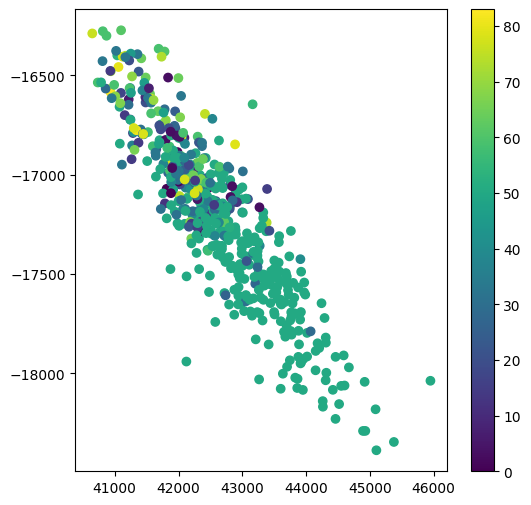

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y)
plt.colorbar()
plt.show()

### Extreme pointes bellow

In [ ]:
np.where(encoded_imgs[:,1]<-18200)

(array([ 21, 125, 251, 389, 451]),)

### middle point

In [ ]:
np.where((encoded_imgs[:,1]>-17350) & (encoded_imgs[:,1]<-17300))

(array([ 15,  64, 101, 144, 173, 193, 224, 225, 232, 339, 347, 379, 384,
        386, 403, 476, 491, 515, 520, 528]),)

### Extreme point above

In [ ]:
np.where(encoded_imgs[:,1]>-16400 )

(array([  6,   8,  32, 154, 163, 165, 212, 235, 275, 436]),)

## Study 3: Analyzis of high-level Concept Detected by developing new CNN model

In [ ]:
insight_concept=np.column_stack((X_data["y"],label,encoded_imgs[:,0],encoded_imgs[:,1]))

In [ ]:
# Save the DataFrame to a CSV file
insight_concept=pd.DataFrame(insight_concept)
insight_concept.to_csv('/content/insight_concept.csv', index=False)

In [ ]:
#initialize target
target=[1]*536

In [ ]:
#get ranks for group 1
group_1=np.where((encoded_imgs[:,1]<=-17487) )

In [ ]:
group_1

(array([ 11,  14,  19,  21,  24,  26,  28,  29,  39,  42,  45,  48,  58,
         59,  60,  65,  66,  67,  70,  72,  80,  84,  89,  93,  94,  99,
        100, 123, 125, 131, 139, 141, 143, 145, 146, 151, 152, 153, 158,
        159, 167, 171, 172, 179, 180, 181, 183, 184, 194, 196, 198, 199,
        200, 203, 205, 208, 217, 228, 229, 233, 234, 239, 245, 247, 249,
        250, 251, 253, 258, 260, 271, 274, 276, 277, 280, 284, 289, 291,
        293, 294, 296, 303, 320, 321, 323, 329, 334, 349, 356, 357, 364,
        368, 369, 370, 375, 376, 382, 389, 396, 400, 410, 414, 418, 422,
        427, 429, 430, 433, 437, 438, 442, 447, 451, 457, 461, 463, 465,
        466, 467, 468, 473, 484, 487, 489, 490, 493, 495, 498, 501, 511,
        517, 527, 533, 535]),)

In [ ]:
#get ranks for group 2
group_2=np.where((encoded_imgs[:,1]<=-17187) & (encoded_imgs[:,1]>-17487)  )

In [ ]:
group_2

(array([  2,   5,  10,  15,  23,  30,  35,  36,  37,  41,  47,  49,  52,
         53,  55,  64,  73,  83,  86,  87,  90,  91,  92,  97,  98, 101,
        104, 107, 109, 110, 113, 114, 115, 118, 132, 136, 142, 144, 164,
        173, 177, 189, 190, 193, 197, 204, 207, 211, 213, 214, 219, 224,
        225, 226, 232, 241, 242, 244, 252, 255, 257, 259, 263, 266, 267,
        268, 269, 282, 297, 305, 310, 314, 317, 319, 322, 324, 325, 330,
        335, 339, 341, 347, 348, 350, 354, 363, 367, 371, 372, 373, 379,
        381, 384, 386, 390, 392, 397, 402, 403, 406, 411, 415, 417, 419,
        421, 425, 439, 443, 446, 452, 460, 462, 471, 472, 476, 480, 483,
        486, 491, 492, 499, 503, 506, 509, 510, 515, 519, 520, 524, 528,
        532, 534]),)

In [ ]:
#get ranks for group 3
group_3=np.where((encoded_imgs[:,1]<=-16934) & (encoded_imgs[:,1]>-17187)  )

In [ ]:
group_3

(array([  0,  16,  17,  22,  25,  31,  40,  43,  44,  46,  50,  51,  54,
         57,  62,  68,  69,  75,  82,  95,  96, 102, 103, 105, 106, 111,
        117, 119, 120, 122, 126, 130, 134, 135, 138, 147, 148, 149, 155,
        157, 160, 161, 162, 169, 174, 182, 191, 192, 195, 201, 206, 209,
        210, 222, 236, 240, 248, 254, 256, 262, 265, 270, 273, 278, 279,
        281, 283, 285, 287, 288, 290, 292, 298, 300, 301, 302, 304, 307,
        308, 309, 316, 318, 326, 328, 333, 336, 337, 338, 342, 343, 344,
        346, 355, 360, 361, 366, 378, 388, 393, 394, 401, 405, 407, 408,
        416, 420, 423, 428, 431, 435, 444, 445, 449, 450, 453, 454, 455,
        456, 459, 464, 475, 477, 482, 485, 488, 494, 497, 500, 502, 504,
        516, 518, 526, 529, 531]),)

In [ ]:
#get ranks for group 4
group_4=np.where((encoded_imgs[:,1]>-16934) )

In [ ]:
group_4

(array([  1,   3,   4,   6,   7,   8,   9,  12,  13,  18,  20,  27,  32,
         33,  34,  38,  56,  61,  63,  71,  74,  76,  77,  78,  79,  81,
         85,  88, 108, 112, 116, 121, 124, 127, 128, 129, 133, 137, 140,
        150, 154, 156, 163, 165, 166, 168, 170, 175, 176, 178, 185, 186,
        187, 188, 202, 212, 215, 216, 218, 220, 221, 223, 227, 230, 231,
        235, 237, 238, 243, 246, 261, 264, 272, 275, 286, 295, 299, 306,
        311, 312, 313, 315, 327, 331, 332, 340, 345, 351, 352, 353, 358,
        359, 362, 365, 374, 377, 380, 383, 385, 387, 391, 395, 398, 399,
        404, 409, 412, 413, 424, 426, 432, 434, 436, 440, 441, 448, 458,
        469, 470, 474, 478, 479, 481, 496, 505, 507, 508, 512, 513, 514,
        521, 522, 523, 525, 530]),)

## Create New Target

In [ ]:
target=np.empty(536)
target.fill(1)

In [ ]:
target=target.astype(str)

In [ ]:
for i in group_1:
  target[i]='group1'

In [ ]:
for i in group_2:
  target[i]='group2'

In [ ]:
for i in group_3:
  target[i]='group3'

In [ ]:
for i in group_4:
  target[i]='group4'

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
image_folder = '/content'

In [ ]:
# Create lists to store images and labels
images = []

# Iterate over the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):  # Change the file extension accordingly
        # Load and preprocess the image
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).resize((64, 64))  # Resize the image if needed
        img_array = np.array(img) / 255.0  # Normalize pixel values to be between 0 and 1
        images.append(img_array)

In [ ]:
#Other way to proceed image load
# Create lists to store images and labels
images = []

# Iterate over the images in the folder
for i in range(1,537):
  # Load and preprocess the image
  img_path = os.path.join('/content/', 'animal_'+str(i)+'.jpg')
  img = Image.open(img_path).resize((64, 64))  # Resize the image if needed
  img_array = np.array(img) / 255.0  # Normalize pixel values to be between 0 and 1
  images.append(img_array)


In [ ]:
# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(target)

In [ ]:
# Shuffle the data
images, labels_encoded = shuffle(images, labels_encoded, random_state=42)

In [ ]:
images=np.asarray(images)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for classification

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if one-hot encoding is used
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 9216)             

In [ ]:
# Set up early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
          callbacks=[early_stopping])

Epoch 1/50
14/14 [==============================] - 2s 71ms/step - loss: 1.4082 - accuracy: 0.2266 - val_loss: 1.3818 - val_accuracy: 0.2778
Epoch 2/50
14/14 [==============================] - 1s 58ms/step - loss: 1.3823 - accuracy: 0.2874 - val_loss: 1.3863 - val_accuracy: 0.2685
Epoch 3/50
14/14 [==============================] - 1s 58ms/step - loss: 1.3821 - accuracy: 0.2710 - val_loss: 1.3993 - val_accuracy: 0.2407
Epoch 4/50
14/14 [==============================] - 1s 57ms/step - loss: 1.3712 - accuracy: 0.2944 - val_loss: 1.3889 - val_accuracy: 0.2037
Epoch 5/50
14/14 [==============================] - 1s 51ms/step - loss: 1.3374 - accuracy: 0.3411 - val_loss: 1.3674 - val_accuracy: 0.3704
Epoch 6/50
14/14 [==============================] - 1s 51ms/step - loss: 1.3517 - accuracy: 0.3411 - val_loss: 1.3672 - val_accuracy: 0.3241
Epoch 7/50
14/14 [==============================] - 1s 51ms/step - loss: 1.2935 - accuracy: 0.4393 - val_loss: 1.4235 - val_accuracy: 0.2870
Epoch 8/50
14

In [ ]:
model

## Explain High-level Concept

In [ ]:
import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/animal_3.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [ ]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 790.8 kB/s eta 0:00:00


In [ ]:
from tf_explain.callbacks.grad_cam import GradCAM

### GradCam: An example

In [ ]:
# Load pretrained model or your own
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img('/content/animal_3.jpg', target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=291)

explainer.save(grid, ".", "/content/drive/grad_cam.png")

### GradCam: Application

In [ ]:
# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img('/content/animal_164.jpg', target_size=(64, 64))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=3)

explainer.save(grid, ".", "/content/drive/grad_cam_164.png")

In [ ]:
########################################################################################################""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save to Drive
np.save('/content/drive/MyDrive/y_encoded.npy', labels_encoded)

In [ ]:
labels_encoded_data=pd.DataFrame(labels_encoded)

In [ ]:
# Save the DataFrame to a CSV file
labels_encoded_data.to_csv('/content/labels_encoded.csv', index=False)

NameError: ignored

In [ ]:
target=np.load('/encoded.npy')

In [ ]:
target

array([3, 2, 4, 2, 3, 2, 3, 0, 4, 3, 2, 0, 2, 2, 2, 0, 0, 3, 2, 0, 3, 0,
       2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 3, 3, 3, 3, 2, 1,
       2, 3, 2, 0, 2, 3, 4, 0, 0, 0, 2, 3, 2, 3, 2, 2, 4, 3, 2, 0, 0, 0,
       2, 3, 2, 0, 1, 4, 4, 4, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0,
       2, 3, 0, 2, 2, 2, 2, 3, 0, 3, 0, 2, 2, 3, 2, 0, 2, 0, 0, 3, 3, 0,
       0, 3, 2, 0, 2, 0, 3, 0, 3, 0, 3, 4, 0, 4, 0, 2, 3, 3, 0, 0, 3, 0,
       3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 2, 3, 0, 4, 4, 1, 3, 2, 2, 3, 2, 1,
       3, 3, 2, 3, 0, 1, 0, 3, 2, 3, 3, 4, 2, 2, 0, 0, 3, 3, 3, 0, 3, 1,
       3, 0, 2, 3, 3, 0, 3, 3, 0, 0, 1, 0, 2, 2, 3, 3, 0, 1, 1, 3, 4, 2,
       2, 0, 3, 2, 3, 0, 4, 1, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 0, 3, 0, 3,
       0, 3, 2, 3, 3, 3, 0, 3, 2, 3, 2, 3, 3, 2, 2, 2, 0, 4, 0, 3, 2, 3,
       3, 2, 0, 3, 3, 1, 0, 3, 3, 4, 2, 0, 0, 0, 3, 0, 2, 0, 2, 2, 2, 2,
       0, 2, 3, 3, 2, 1, 0, 3, 3, 0, 3, 3, 3, 2, 3, 0, 3, 3, 2, 3, 0, 4,
       2, 3, 2, 2, 0, 0, 3, 2, 3, 2, 3, 2, 0, 0, 0,